# 7.6. 残差网络（ResNet）

## 7.6.1. 函数类
首先，假设有一类特定的神经网络架构$\mathcal{F}$，它包括学习速率和其他超参数设置。对于所有$f \in \mathcal{F}$，存在一些参数集（例如权重和偏置），这些参数可以通过在合适的数据集上进行训练而获得。现在假设$f^*$是我们真正想要找到的函数，如果是$f^* \in \mathcal{F}$，那我们可以轻而易举的训练得到它，但通常我们不会那么幸运。相反，我们将尝试找到一个函数$f^*_\mathcal{F}$，这是我们在$\mathcal{F}$中的最佳选择。

例如，给定一个具有$\mathbf{X}$特性和$\mathbf{y}$标签的数据集，我们可以尝试通过解决以下优化问题来找到它：

$$f^*_\mathcal{F} := \mathop{\mathrm{argmin}}_f L(\mathbf{X}, \mathbf{y}, f) \text{ subject to } f \in \mathcal{F}.$$

那么，怎样得到更近似真正$f^*$的函数呢？唯一合理的可能性是，我们需要设计一个更强大的架构$\mathcal{F}'$。换句话说，我们预计$f^*_{\mathcal{F}'}$比$f^*_{\mathcal{F}}$“更近似”。然而，如果$\mathcal{F} \not\subseteq \mathcal{F}'$，则无法保证新的体系“更近似”。
事实上，$f^*_{\mathcal{F}'}$可能更糟：如图所示，对于非嵌套函数（non-nested function）类，较复杂的函数类并不总是向“真”函数$f^*$靠拢（复杂度由$\mathcal{F}_1$向$\mathcal{F}_6$递增）。在图的左边，虽然$\mathcal{F}_3$比$\mathcal{F}_1$更接近$f^*$，但$\mathcal{F}_6$却离的更远了。相反对于图右侧的嵌套函数（nested function）类$\mathcal{F}_1 \subseteq \ldots \subseteq \mathcal{F}_6$，我们可以避免上述问题。

![avatar](../img/7_7.png)

因此，只有当较复杂的函数类包含较小的函数类时，我们才能确保提高它们的性能。对于深度神经网络，如果我们能将新添加的层训练成**恒等映射**（identity function）$f(\mathbf{x}) = \mathbf{x}$，新模型和原模型将同样有效。同时，由于新模型可能得出更优的解来拟合训练数据集，因此添加层似乎更容易降低训练误差。


残差网络的核心思想是：**每个附加层都应该更容易地包含原始函数作为其元素之一**。于是，**残差块**（residual blocks）便诞生了。


## 7.6.2. 残差块
让我们聚焦于神经网络局部：如图所示，假设我们的原始输入为$x$，而希望学出的理想映射为$f(\mathbf{x})$（作为上方激活函数的输入）。左图虚线框中的部分需要直接拟合出该映射$f(\mathbf{x})$，而右图虚线框中的部分则需要拟合出残差映射$f(\mathbf{x}) - \mathbf{x}$。残差映射在现实中往往更容易优化。以本节开头提到的恒等映射作为我们希望学出的理想映射$f(\mathbf{x})$，我们只需将右图虚线框内上方的加权运算（如仿射）的权重和偏置参数设成0，那么$f(\mathbf{x})$即为恒等映射。实际中，当理想映射$f(\mathbf{x})$极接近于恒等映射时，残差映射也易于捕捉恒等映射的细微波动。右图是ResNet的基础架构--**残差块**（residual block）。在残差块中，输入可通过跨层数据线路更快地向前传播。

![avaatr](../img/7_8.png)

ResNet沿用了VGG完整的$3\times 3$卷积层设计。残差块里首先有2个有相同输出通道数的$3\times 3$卷积层。每个卷积层后接一个批量规范化层和ReLU激活函数。然后我们通过跨层数据通路，跳过这2个卷积运算，将输入直接加在最后的ReLU激活函数前。这样的设计要求2个卷积层的输出与输入形状一样，从而使它们可以相加。如果想改变通道数，就需要引入一个额外的$1\times 1$卷积层来将输入变换成需要的形状后再做相加运算。


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

"""
残差块的实现如下：
"""


class Residual(nn.Module):  #@save
    def __init__(self,input_channels,num_channels,use_1x1conv=False,strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels,
                             num_channels,
                             kernel_size=3,
                             padding=1,
                             stride=strides)

        self.conv2 = nn.Conv2d(num_channels,
                               num_channels,
                               kernel_size=3,
                               padding=1)

        if use_1x1conv:
            self.conv3=nn.Conv2d(input_channels,
                                 num_channels,
                                 kernel_size=1,
                                 stride=strides)
        else:
            self.conv3=None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self,X):
        Y = F.relu(self.bn1(self.conv1(X)))

        Y = self.bn2(self.conv2(Y))

        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

![avatar](../img/7_9.png)

In [2]:
"""
查看输入和输出形状一致的情况。
"""
blk1=Residual(3,3)
X=torch.rand(4,3,6,6)
blk1(X).shape  # torch.Size([4, 3, 6, 6])

"""
我们也可以在增加输出通道数的同时，减半输出的高和宽。
"""
blk2=Residual(3,6,use_1x1conv=True,strides=2)
blk2(X).shape  # torch.Size([4, 6, 3, 3])

torch.Size([4, 6, 3, 3])

## 7.6.3. ResNet模型

In [3]:
"""
ResNet的前两层跟之前介绍的GoogLeNet中的一样： 在输出通道数为64、步幅为2的7x7卷积层后，接步幅为2的3x3的最大汇聚层。 不同之处在于ResNet每个卷积层后增加了批量规范化层。
"""
b1=nn.Sequential(
    nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
)

"""
GoogLeNet在后面接了4个由Inception块组成的模块。ResNet则使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。第一个模块的通道数同输入通道数一致。由于之前已经使用了步幅为2的最大汇聚层，所以无须减小高和宽。之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

下面我们来实现这个模块。注意，我们对第一个模块做了特别处理。
"""
def resnet_block(input_channels,num_channels,num_residuals,first_block=False):

    blk=[]

    for i in range(num_residuals):
        if i==0 and not first_block:
            blk.append(Residual(input_channels,num_channels,use_1x1conv=True,strides=2))
        else:
            blk.append(Residual(num_channels,num_channels))

    return blk

"""
接着在ResNet加入所有残差块，这里每个模块使用2个残差块。
"""
b2=nn.Sequential(*resnet_block(64,64,2,first_block=True))
b3=nn.Sequential(*resnet_block(64,128,2))
b4=nn.Sequential(*resnet_block(128,256,2))
b5=nn.Sequential(*resnet_block(256,512,2))

"""
最后，与GoogLeNet一样，在ResNet中加入全局平均汇聚层，以及全连接层输出。
"""

"""
每个模块有4个卷积层（不包括恒等映射的1x1卷积层）。 加上第一个7x7卷积层和最后一个全连接层，共有18层。 因此，这种模型通常被称为ResNet-18。
"""

net=nn.Sequential(
    b1,
    b2,
    b3,
    b4,
    b5,
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(512,10)
)
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-

完整的ResNwt-18架构
![avatar](../img/7_10.png)

In [4]:
"""
在训练ResNet之前，让我们观察一下ResNet中不同模块的输入形状是如何变化的。 在之前所有架构中，分辨率降低，通道数量增加，直到全局平均汇聚层聚集所有特征。
"""
X=torch.rand(size=(1,1,224,224))
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)


Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


## 7.6.4. 训练模型

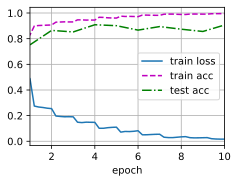

loss 0.017, train acc 0.995, test acc 0.906
2190.4 examples/sec on cuda:0


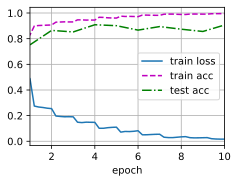

In [5]:
lr,num_epochs,batch_size = 0.05,10,256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size,resize=96)
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

## 7.6.5. 小结
- 学习**嵌套函数**（nested function）是训练神经网络的理想情况。在深层神经网络中，学习另一层作为恒等映射（identity function）较容易（尽管这是一个极端情况）。

- 残差映射可以更容易地学习同一函数，例如将权重层中的参数近似为零。

- 利用残差块（residual blocks）可以训练出一个有效的深层神经网络：输入可以通过层间的残余连接更快地向前传播。

- 残差网络（ResNet）对随后的深层神经网络设计产生了深远影响。